# Paper: 
**Title**:  
   - Semi-Supervised Classification with Graph Convolutional Networks  

**Authors**:  
   - Thomas N. Kipf  
   - Max Welling
    
**Published at**:  
   - ICLR 2017  
   
**Highlights**:  
   - Localized first-order approximation of spectral graph convolutions  
   - Hidden representations encode both local graph structure and features of nodes  
   - Labels only available for small amount of nodes
   - Encodes graph directly using a neural network $f(X,A)$
   - Propose layer-wise propagation rule
   
$$ 
H^{(l+1)} = \sigma(\tilde{D}^{-1/2} \; \tilde{A} \; \tilde{D}^{-1/2}H^{(l)}W^{(l)})
$$ 

Where:

$\tilde{A}=A+I_{N} \rightarrow$ adjacency matrix with self-connections   
$\tilde{D}_{ii}=\sum_{j}\tilde{A}_{ij} \rightarrow$ degree matrix  
$W^{(l)} \rightarrow$ trainable weight matrix  
$ \sigma(\cdot) \rightarrow$ non-linear activation function (ReLU, TanH, etc)  
$H^{(l)} \rightarrow$ activation matrix from previous layers  
$H^{(0)} \rightarrow$ input features (node features)

**Training Details**:  
   - Trained with Batch Gradient Descent
   - Cross entropy loss function
   - Introduce stochasticity with dropout
   
**Limitations**:  
   - Does not (naturally) support edge features
   - Limited to undirected graph (weighted or unweighted)
   - Implicity assume locality and equal importance of self connections vs. edges to neighboring nodes. For some datasets this can be weighted by a trade-off parameter $\lambda$:  
$\tilde{A}=A+\lambda I_{N}$

In [1]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.karate_club_graph()
print("Node Degree")
for v in G:
    print(f"{v:4} {G.degree(v):6}")

Node Degree
   0     16
   1      9
   2     10
   3      6
   4      3
   5      4
   6      4
   7      4
   8      5
   9      2
  10      3
  11      1
  12      2
  13      5
  14      2
  15      2
  16      2
  17      2
  18      2
  19      3
  20      2
  21      2
  22      2
  23      5
  24      3
  25      3
  26      2
  27      4
  28      3
  29      4
  30      4
  31      6
  32     12
  33     17


In [2]:
nx.adjacency_data(G)['nodes']

[{'club': 'Mr. Hi', 'id': 0},
 {'club': 'Mr. Hi', 'id': 1},
 {'club': 'Mr. Hi', 'id': 2},
 {'club': 'Mr. Hi', 'id': 3},
 {'club': 'Mr. Hi', 'id': 4},
 {'club': 'Mr. Hi', 'id': 5},
 {'club': 'Mr. Hi', 'id': 6},
 {'club': 'Mr. Hi', 'id': 7},
 {'club': 'Mr. Hi', 'id': 8},
 {'club': 'Officer', 'id': 9},
 {'club': 'Mr. Hi', 'id': 10},
 {'club': 'Mr. Hi', 'id': 11},
 {'club': 'Mr. Hi', 'id': 12},
 {'club': 'Mr. Hi', 'id': 13},
 {'club': 'Officer', 'id': 14},
 {'club': 'Officer', 'id': 15},
 {'club': 'Mr. Hi', 'id': 16},
 {'club': 'Mr. Hi', 'id': 17},
 {'club': 'Officer', 'id': 18},
 {'club': 'Mr. Hi', 'id': 19},
 {'club': 'Officer', 'id': 20},
 {'club': 'Mr. Hi', 'id': 21},
 {'club': 'Officer', 'id': 22},
 {'club': 'Officer', 'id': 23},
 {'club': 'Officer', 'id': 24},
 {'club': 'Officer', 'id': 25},
 {'club': 'Officer', 'id': 26},
 {'club': 'Officer', 'id': 27},
 {'club': 'Officer', 'id': 28},
 {'club': 'Officer', 'id': 29},
 {'club': 'Officer', 'id': 30},
 {'club': 'Officer', 'id': 31},
 {'

In [3]:
A = nx.adjacency_matrix(G).todense()
A.mean()

0.13494809688581316

## GCN using Pure Numpy

In [27]:
import numpy as np
from scipy.linalg import sqrtm 
from scipy.special import softmax
import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
from IPython.display import HTML

In [8]:
def draw_kkl(nx_G, label_map, node_color, pos=None, **kwargs):
    fig, ax = plt.subplots(figsize=(10,10))
    if pos is None:
        pos = nx.spring_layout(nx_G, k=5/np.sqrt(nx_G.number_of_nodes()))

    nx.draw(
        nx_G, pos, with_labels=label_map is not None, 
        labels=label_map, 
        node_color=node_color, 
        ax=ax, **kwargs)

In [10]:
g = nx.karate_club_graph()

In [11]:
g.number_of_nodes(), g.number_of_edges()

(34, 78)

In [12]:
communities = greedy_modularity_communities(g)
communities

[frozenset({8,
            14,
            15,
            18,
            20,
            22,
            23,
            24,
            25,
            26,
            27,
            28,
            29,
            30,
            31,
            32,
            33}),
 frozenset({1, 2, 3, 7, 9, 12, 13, 17, 21}),
 frozenset({0, 4, 5, 6, 10, 11, 16, 19})]

In [13]:
g.number_of_nodes()

34

In [15]:
colors = np.zeros(g.number_of_nodes())
colors

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [16]:
for i, com in enumerate(communities):
    print(com)
    colors[list(com)] = i

frozenset({32, 33, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31})
frozenset({1, 2, 3, 7, 9, 12, 13, 17, 21})
frozenset({0, 4, 5, 6, 10, 11, 16, 19})


In [18]:
n_classes = np.unique(colors).shape[0]
n_classes

3

In [22]:
np.eye(n_classes)[colors.astype(int)]

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [19]:
labels = np.eye(n_classes)[colors.astype(int)]
labels

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [23]:
club_labels = nx.get_node_attributes(g,'club')
club_labels

{0: 'Mr. Hi',
 1: 'Mr. Hi',
 2: 'Mr. Hi',
 3: 'Mr. Hi',
 4: 'Mr. Hi',
 5: 'Mr. Hi',
 6: 'Mr. Hi',
 7: 'Mr. Hi',
 8: 'Mr. Hi',
 9: 'Officer',
 10: 'Mr. Hi',
 11: 'Mr. Hi',
 12: 'Mr. Hi',
 13: 'Mr. Hi',
 14: 'Officer',
 15: 'Officer',
 16: 'Mr. Hi',
 17: 'Mr. Hi',
 18: 'Officer',
 19: 'Mr. Hi',
 20: 'Officer',
 21: 'Mr. Hi',
 22: 'Officer',
 23: 'Officer',
 24: 'Officer',
 25: 'Officer',
 26: 'Officer',
 27: 'Officer',
 28: 'Officer',
 29: 'Officer',
 30: 'Officer',
 31: 'Officer',
 32: 'Officer',
 33: 'Officer'}

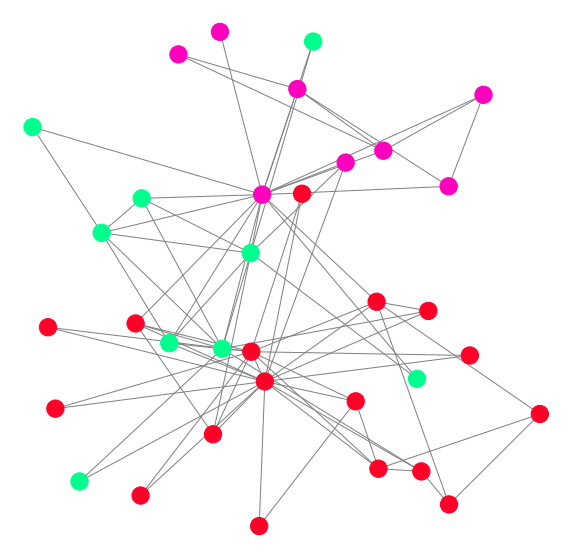

In [24]:
_ = draw_kkl(g, None, colors, cmap='gist_rainbow', edge_color='gray')


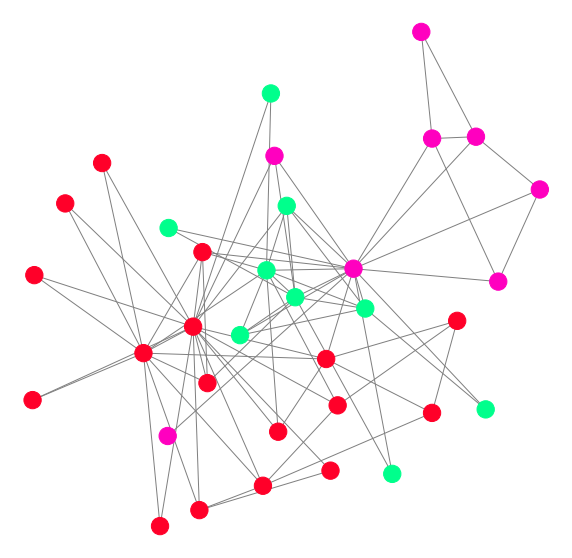

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
pos = nx.spring_layout(g, k=5/np.sqrt(g.number_of_nodes()))
kwargs = {"cmap": 'gist_rainbow', "edge_color":'gray'}
nx.draw(
    g, pos, with_labels=False, 
    node_color=colors, 
    ax=ax, **kwargs)

In [39]:
A.shape[0]

34

In [40]:
def _get_A_tilde(adjacency):
    return adjacency + np.eye(adjacency.shape[0])

In [55]:
def _get_D_tilde_inv(adjacency):
    A_tilde = _get_A_tilde(adjacency)
    D = np.zeros(A_tilde.shape)
    np.fill_diagonal(D, A_tilde.sum(axis=0))
    D_tilde = np.linalg.inv(sqrtm(D))
    return D_tilde

In [56]:
A_tilde = _get_A_tilde(A)
A_tilde

matrix([[1., 1., 1., ..., 1., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 1., 0.],
        ...,
        [1., 0., 0., ..., 1., 1., 1.],
        [0., 0., 1., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.]])

In [58]:
D_tilde_inv = _get_D_tilde_inv(A)
D_tilde_inv

array([[0.24253563, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.31622777, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.30151134, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.37796447, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.2773501 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.23570226]])

In [59]:
A_hat = D_tilde_inv @ A_tilde @ D_tilde_inv
A_hat

matrix([[0.05882353, 0.0766965 , 0.07312724, ..., 0.09166985, 0.        ,
         0.        ],
        [0.0766965 , 0.1       , 0.09534626, ..., 0.        , 0.        ,
         0.        ],
        [0.07312724, 0.09534626, 0.09090909, ..., 0.        , 0.0836242 ,
         0.        ],
        ...,
        [0.09166985, 0.        , 0.        , ..., 0.14285714, 0.10482848,
         0.08908708],
        [0.        , 0.        , 0.0836242 , ..., 0.10482848, 0.07692308,
         0.06537205],
        [0.        , 0.        , 0.        , ..., 0.08908708, 0.06537205,
         0.05555556]])

In [62]:
## Input Matrix
X = np.eye(g.number_of_nodes())
X.shape

(34, 34)

In [64]:
class GCN(object):
    def __init__(self):
        pass
    def forward(self):
        pass
    def backward(self):
        pass

## GCN using PyTorch Geometric

In [5]:
#!pip install torch-scatter
#!pip install torch-sparse
#!pip install torch-cluster
#!pip install torch-spline-conv
#!pip install torch-geometric

In [6]:
import torch
from torch_geometric.data import Data

## Sources
- https://www.youtube.com/watch?v=uMtDrG107Ws
- [Zak Jost - GCN Citeseer](https://github.com/zjost/blog_code/blob/master/gcn_citeseer/gcn-citeseer-example.ipynb)
- [Zak Jost - GCN Numpy](https://github.com/zjost/blog_code/blob/master/gcn_numpy/gcn_from_scratch.ipynb)

---

In [ ]:
import numpy as np
from scipy.linalg import sqrtm 
from scipy.special import softmax
import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
from IPython.display import HTML

In [ ]:
num_nodes = 10
edge_list = [
    [4], #1
    [5], #2
    [4], #3
    [1,3,5,6], #4
    [4], #5
    [4,7], #6
    [8], #7
    [7, 9, 10], #8
    [8], #9
    [8] #19
]

In [ ]:
G = nx.make_small_graph(
    ["adjacencylist", "C_4", num_nodes, edge_list]
)
A = nx.adjacency_matrix(G).todense()
A

In [ ]:
def _get_degree_matrix(adjacency: np.matrix) -> np.matrix:
    D = np.zeros(adjacency.shape)
    np.fill_diagonal(D, adjacency.sum(axis=0))
    return np.matrix(D)

In [ ]:
def _get_laplacian_matrix(adjacency: np.matrix) -> np.matrix:
    D = _get_degree_matrix(adjacency)
    return D-A

In [ ]:
D = _get_degree_matrix(A)
D

In [ ]:
L = _get_laplacian_matrix(A)
L

In [ ]:
A.flatten()

In [ ]:
w, v = np.linalg.eig(A)